In [ ]:
!pip install kaggle

In [1]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 198 kB 14.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=5874d93fbb648b4247376eb2e1509d6fe44e1c41caa754176cf9f09af9382b87
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('Rekdat').getOrCreate()
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
import warnings
warnings.filterwarnings("ignore")

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, explode, regexp_replace, split
import seaborn as sns


os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Rekdat'

#**Extracting and Cleaning Data**

In [4]:
!kaggle datasets download -d dhruvildave/spotify-charts #

 99% 890M/899M [00:08<00:00, 97.2MB/s]
100% 899M/899M [00:08<00:00, 108MB/s] 


In [5]:
!unzip "/content/spotify-charts.zip" -d "/content"

Archive:  /content/spotify-charts.zip
  inflating: /content/charts.csv     


##**Data ke-1 : Spotify Charts**

In [6]:
# Data ke-1
# Read Spotify Chart data

df_sc = spark.read.option("header", "true").csv(path='/content/charts.csv', inferSchema=True).cache()
df_sc.show(5)
print((df_sc.count(), len(df_sc.columns))) # Count data row and col

+--------------------+----+----------+----------+--------------------+---------+------+-------------+-------+
|               title|rank|      date|    artist|                 url|   region| chart|        trend|streams|
+--------------------+----+----------+----------+--------------------+---------+------+-------------+-------+
|Despacito (Featur...|   1|2017-03-01|Luis Fonsi|https://open.spot...|Argentina|top200|SAME_POSITION| 365941|
|           El Amante|   2|2017-03-01| Nicky Jam|https://open.spot...|Argentina|top200|SAME_POSITION| 179697|
|Reggaetón Lento (...|   3|2017-03-01|      CNCO|https://open.spot...|Argentina|top200|SAME_POSITION| 169647|
|        Shape of You|   4|2017-03-01|Ed Sheeran|https://open.spot...|Argentina|top200|SAME_POSITION| 168495|
|Chantaje (feat. M...|   5|2017-03-01|   Shakira|https://open.spot...|Argentina|top200|SAME_POSITION| 141696|
+--------------------+----+----------+----------+--------------------+---------+------+-------------+-------+
only showi

In [7]:
# Drop duplicated row data, filter NULL stream, and drop unused columns from Spotify Chart

df_sc = df_sc.dropDuplicates(["url"]) 
df_sc = df_sc.filter(df_sc['streams'].isNotNull()) 
df_sc = df_sc.drop("chart", "trend") 

print((df_sc.count(), len(df_sc.columns))) # Re-count data row and col

(115334, 7)


##**Data ke-2 : Spotify Top 50 (Indonesia)**

In [8]:
# Data ke-2
# Read Spotify Top 50 (Indonesia) data

df_id = spark.read.option("header", "true").csv(path='/content/gdrive/MyDrive/Rekdat/top_50_-_indonesia.csv', inferSchema=True).cache()
df_id.show(5)
print((df_id.count(), len(df_id.columns))) # Count data row and col

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------+------------+-------------------+--------------------+--------+----------+-------------+-------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|           Track URI|          Track Name|       Artist URI(s)|      Artist Name(s)|           Album URI|          Album Name| Album Artist URI(s)|Album Artist Name(s)|Album Release Date|     Album Image URL|Disc Number|Track Number|Track Duration (ms)|   Track Preview URL|Explicit|Popularity|     Added By|           Added At|       Artist Genres|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Time Signature|Albu

In [9]:
# Replace whitespaces and '(s)' in Column Name

df_id = df_id.select([F.col(col).alias(col.replace(' ', '_')) for col in df_id.columns])
df_id = df_id.select([F.col(col).alias(col.replace('(s)', 's')) for col in df_id.columns])

In [10]:
df_id.printSchema()

root
 |-- Track_URI: string (nullable = true)
 |-- Track_Name: string (nullable = true)
 |-- Artist_URIs: string (nullable = true)
 |-- Artist_Names: string (nullable = true)
 |-- Album_URI: string (nullable = true)
 |-- Album_Name: string (nullable = true)
 |-- Album_Artist_URIs: string (nullable = true)
 |-- Album_Artist_Names: string (nullable = true)
 |-- Album_Release_Date: string (nullable = true)
 |-- Album_Image_URL: string (nullable = true)
 |-- Disc_Number: integer (nullable = true)
 |-- Track_Number: integer (nullable = true)
 |-- Track_Duration_(ms): integer (nullable = true)
 |-- Track_Preview_URL: string (nullable = true)
 |-- Explicit: boolean (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- Added_By: string (nullable = true)
 |-- Added_At: timestamp (nullable = true)
 |-- Artist_Genres: string (nullable = true)
 |-- Danceability: double (nullable = true)
 |-- Energy: double (nullable = true)
 |-- Key: integer (nullable = true)
 |-- Loudness: double (nul

##**Data ke-3 : Spotify API**

In [11]:
# Data ke-3
# Load dari Spotify API
import base64
import datetime
from urllib.parse import urlencode
import json
import requests

In [12]:
class SpotifyAPI(object):
    access_token = None
    access_token_expires = datetime.datetime.now()
    access_token_did_expire = True
    client_id = None
    client_secret = None
    token_url = "https://accounts.spotify.com/api/token"
    
    def __init__(self, client_id, client_secret, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.client_id = client_id
        self.client_secret = client_secret

    def get_client_credentials(self):
        """
        Returns a base64 encoded string
        """
        client_id = self.client_id
        client_secret = self.client_secret
        if client_secret == None or client_id == None:
            raise Exception("You must set client_id and client_secret")
        client_creds = f"{client_id}:{client_secret}"
        client_creds_b64 = base64.b64encode(client_creds.encode())
        return client_creds_b64.decode()
    
    def get_token_headers(self):
        client_creds_b64 = self.get_client_credentials()
        return {
            "Authorization": f"Basic {client_creds_b64}"
        }
    
    def get_token_data(self):
        return {
            "grant_type": "client_credentials"
        } 
    
    def perform_auth(self):
        token_url = self.token_url
        token_data = self.get_token_data()
        token_headers = self.get_token_headers()
        r = requests.post(token_url, data=token_data, headers=token_headers)
        if r.status_code not in range(200, 299):
            raise Exception("Could not authenticate client.")
            # return False
        data = r.json()
        now = datetime.datetime.now()
        access_token = data['access_token']
        expires_in = data['expires_in'] # seconds
        expires = now + datetime.timedelta(seconds=expires_in)
        self.access_token = access_token
        self.access_token_expires = expires
        self.access_token_did_expire = expires < now
        return True
    
    def get_access_token(self):
        token = self.access_token
        expires = self.access_token_expires
        now = datetime.datetime.now()
        if expires < now:
            self.perform_auth()
            return self.get_access_token()
        elif token == None:
            self.perform_auth()
            return self.get_access_token() 
        return token
    
    def get_resource_header(self):
        access_token = self.get_access_token()
        headers = {
            "Authorization": f"Bearer {access_token}"
        }
        return headers
        
        
    def get_resource(self, lookup_id, resource_type='albums', version='v1'):
        endpoint = f"https://api.spotify.com/{version}/{resource_type}/{lookup_id}"
        headers = self.get_resource_header()
        r = requests.get(endpoint, headers=headers)
        if r.status_code not in range(200, 299):
            return {}
        return r.json()
    
    def get_album(self, _id):
        return self.get_resource(_id, resource_type='albums')
    
    def get_artist(self, _id):
        return self.get_resource(_id, resource_type='artists')

    def get_track(self, _id):
        return self.get_resource(_id, resource_type='track')
    
    def base_search(self, query_params): # type
        headers = self.get_resource_header()
        endpoint = "https://api.spotify.com/v1/search"
        lookup_url = f"{endpoint}?{query_params}"
        r = requests.get(lookup_url, headers=headers)
        if r.status_code not in range(200, 299):  
            return {}
        return r.json()
    
    def search(self, query=None, operator=None, operator_query=None, search_type='artist' ):
        if query == None:
            raise Exception("A query is required")
        if isinstance(query, dict):
            query = " ".join([f"{k}:{v}" for k,v in query.items()])
        if operator != None and operator_query != None:
            if operator.lower() == "or" or operator.lower() == "not":
                operator = operator.upper()
                if isinstance(operator_query, str):
                    query = f"{query} {operator} {operator_query}"
        query_params = urlencode({"q": query, "type": search_type.lower()})
        print(query_params)
        return self.base_search(query_params)

In [13]:
spotify = SpotifyAPI('d18954b22f8441518386dbd0042269df', 'afcec34423284ad6997cf0d6ef2580a6')

In [17]:
artist_arr = np.array(df.select("artist").collect())

In [18]:
# Split each row value into one array component

artist_split = []
for i in range(0, len(artist_arr)):
  for j in range(0, len(artist_arr[i])):
    e = artist_arr[i][j]
    el = str(e)
    ele = el.split(',')
    artist_split.append(ele)

In [19]:
#Split each element in array into one value

artist_split2 = []
for i in range(0, len(artist_split)):
  for j in range(0, len(artist_split[i])):
    e = artist_split[i][j]
    el = e.split(',')
    artist_split2.append(el)

In [20]:
#Append value into single array

artist_split3 = []
for i in range(0, len(artist_split2)):
  for j in range(0, len(artist_split2[i])):
    e = artist_split2[i][j]
    artist_split3.append(e)

In [21]:
artist_result = []
for artist_name in artist_split3:
  query = spotify.search(artist_name, search_type='artist')
  artist_result.append(query)

q=STIKSTOF&type=artist
q=Zoe+Wees&type=artist
q=Dere&type=artist
q=JKT48&type=artist
q=Ndarboy+Genk&type=artist
q=Adele&type=artist
q=Gerry+Cinnamon&type=artist
q=The+Walters&type=artist
q=LeeHi&type=artist
q=WizKid&type=artist
q=Juicy+Luicy&type=artist
q=Shanna+Shannon&type=artist
q=Christopher&type=artist
q=Lil+Nas+X&type=artist
q=dhruv&type=artist
q=187+Strassenbande&type=artist
q=+LX&type=artist
q=Jamie+Miller&type=artist
q=Rasskulz&type=artist
q=+BKO&type=artist
q=+Saffeh&type=artist
q=Lost+Boyz&type=artist
q=Celina+Sharma&type=artist
q=+Harris+J.&type=artist
q=Coldplay&type=artist
q=+BTS&type=artist
q=Lyodra&type=artist
q=Glass+Animals&type=artist
q=Skip+the+Use&type=artist
q=Henry&type=artist
q=Joji&type=artist
q=Arsy+Widianto&type=artist
q=+Tiara+Andini&type=artist
q=Ilian&type=artist
q=The+Neighbourhood&type=artist
q=Mr.+Polska&type=artist
q=+Malik+Montana&type=artist
q=+Abel+de+Jong&type=artist
q=Olivia+Rodrigo&type=artist
q=Ali+Gatie&type=artist
q=Last+Child&type=artist
q=El

In [22]:
#Split each element in array into one value

artist_result_split2 = []
index = np.array([3, 16,17])
for i in range(0, len(artist_result) - 80):
  for j in index:
    e = artist_split[i][0]
    el = e.split(',')
    artist_result_split2.append(el)

In [23]:
# Split each row value into one array component

query_split = []
for i in range(0, len(artist_result)):
    e = artist_result[i]
    el = str(e)
    ele = el.split(',')
    query_split.append(ele)

In [24]:
artist_array_res = np.array(artist_result)

In [25]:
artist_data = []
fetch = artist_array_res

artist_name = []
artist_followers = []
artist_popularity = []

for i in range(0, len(artist_array_res)):
  temp = artist_array_res[i]
  fetch_res = json.dumps(temp)
  fetch_load = json.loads(fetch_res)
  extract_name = fetch_load['artists']['items'][0]['name']
  extract_followers = fetch_load['artists']['items'][0]['followers']['total']
  extract_popularity = fetch_load['artists']['items'][0]['popularity']
  artist_name.append(extract_name)
  artist_followers.append(extract_followers)
  artist_popularity.append(extract_popularity)


In [26]:
artist_data_result = np.stack((artist_name, artist_followers, artist_popularity))
artist_data_columns = ['name', 'followers']

In [27]:
# Convert to Spark Dataframe

artist_df = pd.DataFrame({'name': artist_name, 'followers': artist_followers})
artist_df = spark.createDataFrame(artist_df) 
artist_df.show()

+-------------------+---------+
|               name|followers|
+-------------------+---------+
|           STIKSTOF|    15542|
|           Zoe Wees|   260504|
|Derek & The Dominos|   517591|
|              JKT48|    99237|
|       Ndarboy Genk|   146246|
|              Adele| 31311072|
|     Gerry Cinnamon|   397728|
|        The Walters|   243053|
|              LeeHi|  1098743|
|             WizKid|  1226683|
|        Juicy Luicy|   216043|
|     Shanna Shannon|    10851|
|Christopher Jackson|    34400|
|          Lil Nas X|  7736095|
|              dhruv|   161407|
|  187 Strassenbande|  1256597|
|       LXST CXNTURY|   202843|
|       Jamie Miller|   159011|
|           Rasskulz|     2974|
|                BKO|    25887|
+-------------------+---------+
only showing top 20 rows



#**Transforming Data**

**Spotify Chart and Top 50 Indonesia**

In [16]:
# Inner Join Spotify Chart and Spotify Top 50 (Indonesia) 

df = df_sc.join(df_id,df_sc.title ==  df_id.Track_Name,"inner")
df.show()

+--------------------+----+----------+--------------------+--------------------+------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+------------+-------------------+--------------------+--------+----------+-------------+-------------------+--------------------+------------+------+----+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|               title|rank|      date|              artist|                 url|      region|streams|           Track_URI|          Track_Name|         Artist_URIs|        Artist_Names|           Album_URI|         Album_Name|   Album_Artist_URIs|  Album_Artist_Names|Album_Release_Date|     Album_Image_URL|Disc_Number|Track_Number|Track_Duration_(ms)|   Track_Preview_URL|

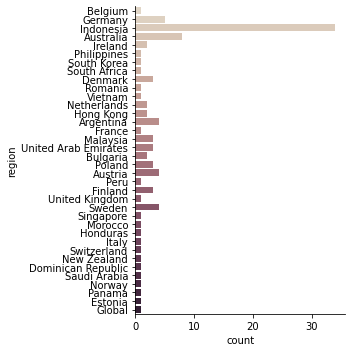

In [28]:
df_region = df.toPandas()
sns.catplot(y="region", kind="count", palette="ch:.25", data=df_region)

In [30]:
# Filter Indonesia Region Only. drop unused columns, drop the remaining duplicated song

df = df.filter(df['region'].contains('Indonesia'))
df = df.drop("Track_URIs","Artist_URIs","Album_URI","Album_Artist_URIs","Album_Release_Date",
             "Album_Image_URL","Disc_Number","Track_Number","Track_Duration_(ms)","Track_URI",
             "Track_Preview_URL","Explicit","Added_By","Added_At","Album_Artist_Names","url","Track_Name",
             "Track_Name","Artist_Names","rank")
df = df.dropDuplicates(["title","Album_Name"])
df.orderBy(['Popularity'], ascending = [False]).show() # Show data order by popularity

+--------------------+----------+--------------------+---------+-------+--------------------+----------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|               title|      date|              artist|   region|streams|          Album_Name|Popularity|       Artist_Genres|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Time_Signature|Album_Genres|               Label|          Copyrights|
+--------------------+----------+--------------------+---------+-------+--------------------+----------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|               Ghost|2020-05-25|            BAEKHYUN|Indonesia|  27079|             Justice|    

In [ ]:
print((df.count(), len(df.columns))) # Count joined data row and col

(30, 23)


In [31]:
# Split object strings of Artist_Genres

df_split = df.withColumn(
    "Artist_Genres", 
    explode(split(regexp_replace(col("Artist_Genres"), "(^\[)|(\]$)", ""), ","))
)

In [32]:
df_split = df.select('title','date','artist','region','streams','Album_Name','Popularity',explode(split(regexp_replace(col("Artist_Genres"), "(^\[)|(\]$)", ""), ",")))
df_split = df_split.withColumnRenamed("col", "Artist_Genres")
print((df_split.count(), len(df_split.columns)))
df_split.show()

(63, 8)
+-----------------+----------+--------------------+---------+-------+-------------------+----------+--------------------+
|            title|      date|              artist|   region|streams|         Album_Name|Popularity|       Artist_Genres|
+-----------------+----------+--------------------+---------+-------+-------------------+----------+--------------------+
|Akhir Tak Bahagia|2021-04-01|            Misellia|Indonesia|  58347|  Akhir Tak Bahagia|        75|      indonesian pop|
|           Bahaya|2021-03-07|Arsy Widianto, Ti...|Indonesia|  31924|   ArTi Untuk Cinta|        67|      indonesian pop|
|           Bahaya|2021-03-07|Arsy Widianto, Ti...|Indonesia|  31924|   ArTi Untuk Cinta|        67|      indonesian pop|
|          Bertaut|2020-06-01|        Nadin Amizah|Indonesia|  51904|Selamat Ulang Tahun|        74|      indonesian pop|
|       Blue Jeans|2020-12-01|              GANGGA|Indonesia|  70793|         Blue Jeans|        76|indonesian lo-fi pop|
|       Blue Jea

In [33]:
# Count Artist_Genres

genres2_cnt = df_split.groupBy('Artist_Genres').count()
genres2_cnt.orderBy('count', ascending=False).show()

+--------------------+-----+
|       Artist_Genres|count|
+--------------------+-----+
|      indonesian pop|   25|
|                 pop|    5|
|indonesian singer...|    3|
|           chill r&b|    2|
|        canadian pop|    2|
|     indonesian jazz|    2|
| indonesian pop punk|    2|
|indonesian lo-fi pop|    2|
|    indonesian indie|    2|
|   singer-songwriter|    1|
|            boy band|    1|
|           latin pop|    1|
|singaporean singe...|    1|
| indonesian idol pop|    1|
|            pop soul|    1|
|         mexican pop|    1|
|    javanese dangdut|    1|
|canadian contempo...|    1|
| indonesian folk pop|    1|
|            pop rock|    1|
+--------------------+-----+
only showing top 20 rows



In [34]:
df_splitArtist = df.withColumn(
    "artist", 
    explode(split(regexp_replace(col("artist"), "(^\[)|(\]$)", ""), ", "))
)
df_splitArtist = df_splitArtist.drop("title","date","region","streams","Album_Name","Artist_Genres")
df_splitArtist = df_splitArtist.withColumnRenamed("Popularity", "song_popularity")
df_splitArtist.show()

+-------------+---------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|       artist|song_popularity|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Time_Signature|Album_Genres|               Label|          Copyrights|
+-------------+---------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+------------+--------------------+--------------------+
|Celina Sharma|             76|       0.704| 0.638| 10|  -2.834|   1|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|             4|        null|       Mugal Records|C 2021 Mugal Reco...|
|    Harris J.|             76|       0.704| 0.638| 10|  -2.834|   1|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|             4|        null|       M

In [35]:
# Join artist_df and df_splitArtist

df_artist = df_splitArtist.join(artist_df,df_splitArtist.artist ==  artist_df.name,"inner")
df_artist = df_artist.drop("name")
df_artist = df_artist.drop("Key", "Mode", "Time_Signature", "Album_Genres", "Label", "Copyrights")
df_artist = df_artist.na.drop()
df_artist.show(100)

+----------------+---------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+---------+
|          artist|song_popularity|Danceability|Energy|Loudness|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|followers|
+----------------+---------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+---------+
|   Celina Sharma|             76|       0.704| 0.638|  -2.834|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|    13002|
|       Harris J.|             76|       0.704| 0.638|  -2.834|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|   174654|
|        Misellia|             75|       0.535| 0.217| -10.603|     0.0318|       0.921|         1.56E-5|   0.105|  0.313|131.981|    87321|
|   Arsy Widianto|             67|       0.635| 0.388|  -8.647|     0.0285|       0.861|         3.27E-4|   0.111|  0.432|126.062|   352652|
|   Arsy Widi

In [36]:
df_stats = df_artist.select("Danceability", "Energy", "Loudness", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", "Valence", "Tempo")
df_stats.show()

+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|Danceability|Energy|Loudness|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|
+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|       0.704| 0.638|  -2.834|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|
|       0.704| 0.638|  -2.834|     0.0742|       0.385|             0.0|  0.0683|  0.386|107.974|
|       0.535| 0.217| -10.603|     0.0318|       0.921|         1.56E-5|   0.105|  0.313|131.981|
|       0.635| 0.388|  -8.647|     0.0285|       0.861|         3.27E-4|   0.111|  0.432|126.062|
|       0.635| 0.388|  -8.647|     0.0285|       0.861|         3.27E-4|   0.111|  0.432|126.062|
|       0.635| 0.388|  -8.647|     0.0285|       0.861|         3.27E-4|   0.111|  0.432|126.062|
|       0.635| 0.388|  -8.647|     0.0285|       0.861|         3.27E-4|   0.111|  0.432|126.062|
|        0.47| 0.131

#**Load and Visualization**

##**Visualization : Artist Genres Count**

In [37]:
# Convert dataframe to pandas for visualization

df_split_pd = df_split.toPandas()

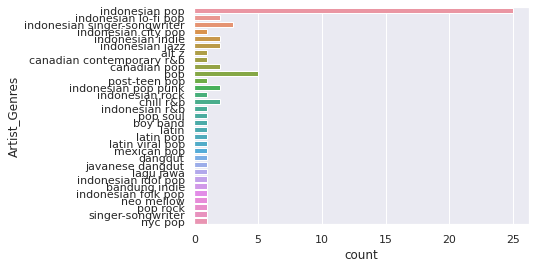

In [38]:
# Barplot Artist_Genres Count

sns.set_theme(style="darkgrid")
ax = sns.countplot(y='Artist_Genres', data=df_split_pd)
sns.set(rc = {'figure.figsize':(10,10)})


##**Visualization : Followers and Song Popularity**

In [39]:
# Convert dataframe to pandas for visualization

df_artist_pd = df_artist.toPandas()

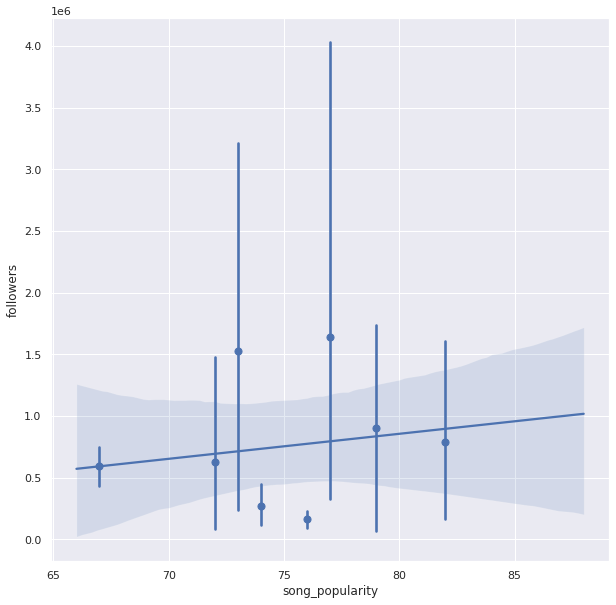

In [40]:
# Regression plot representation correlation of followers and song popularity

ax = sns.regplot(x="song_popularity", y="followers", data=df_artist_pd, x_bins=10)

## Visualization : Song Attribute Statistic

In [41]:
df_stats= df_stats.toPandas()

Mean value for danceability: 0.5906976744186045


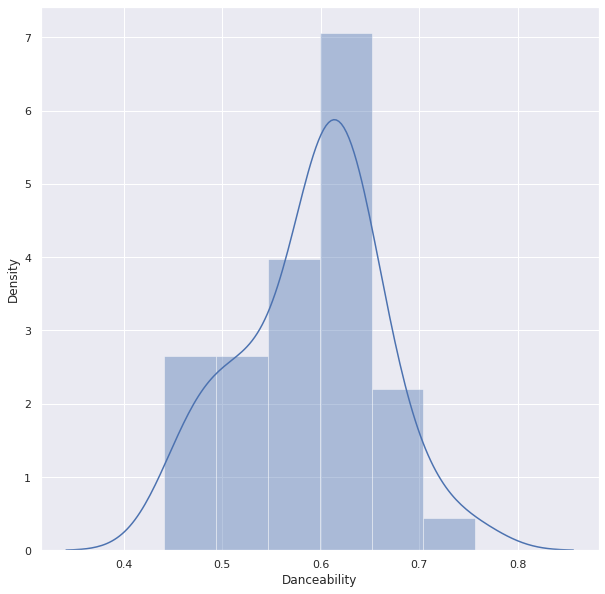

In [42]:
print("Mean value for danceability:", df_stats['Danceability'].mean())
sns.distplot(df_stats['Danceability'])
plt.show()

Mean value for Energy: 0.4759534883720929


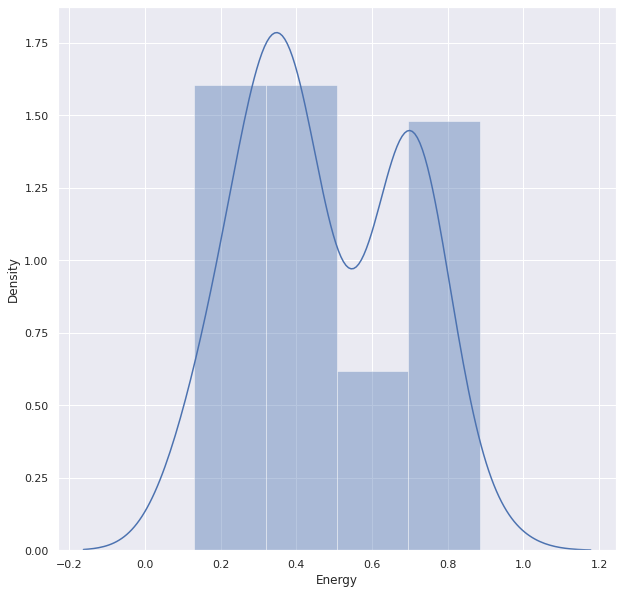

In [43]:
print("Mean value for Energy:", df_stats['Energy'].mean())
sns.distplot(df_stats['Energy'])
plt.show()

Mean value for Loudness: -7.897953488372093


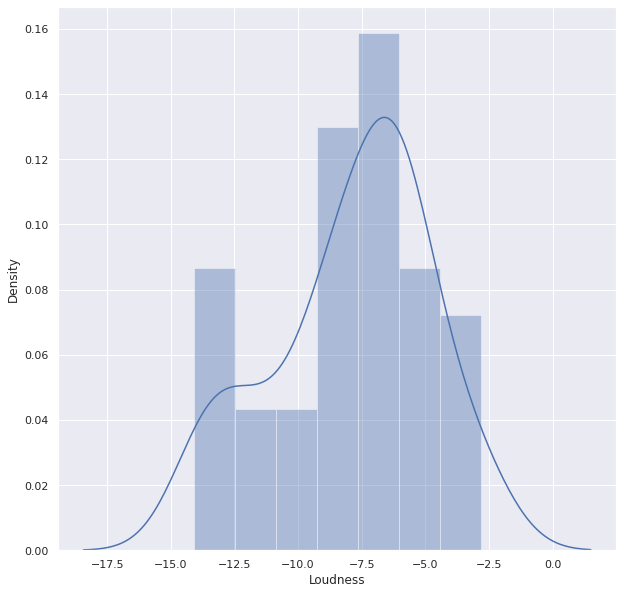

In [44]:
print("Mean value for Loudness:", df_stats['Loudness'].mean())
sns.distplot(df_stats['Loudness'])
plt.show()

Mean value for Speechiness: 0.03506279069767441


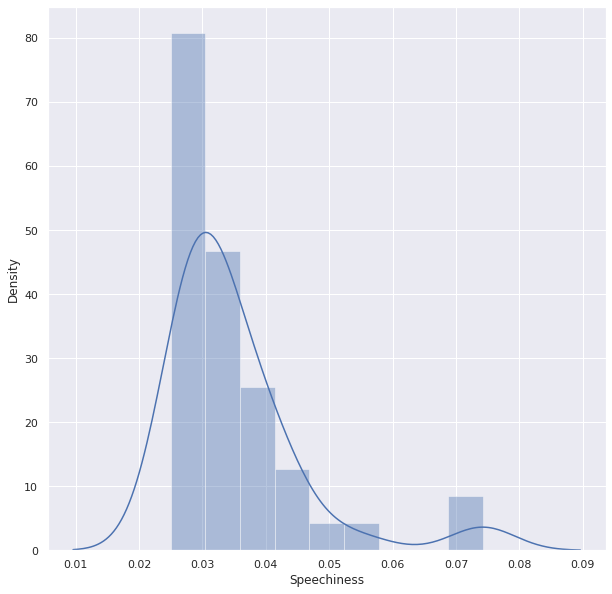

In [45]:
print("Mean value for Speechiness:", df_stats['Speechiness'].mean())
sns.distplot(df_stats['Speechiness'])
plt.show()

Mean value for Acousticness: 0.5481232558139535


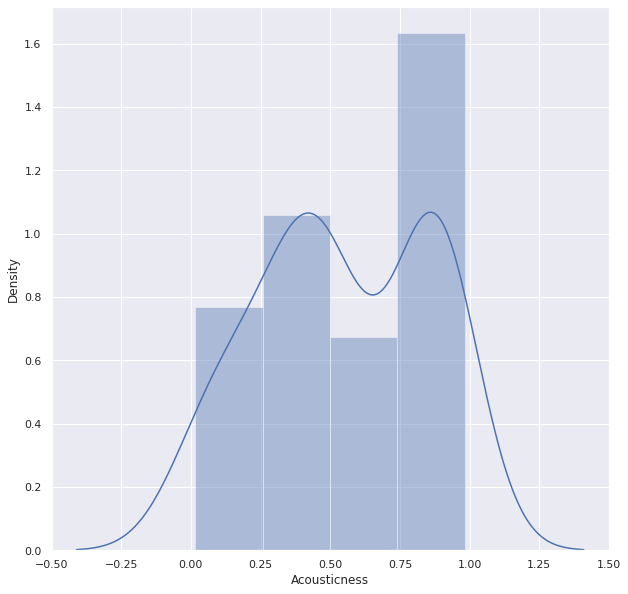

In [46]:
print("Mean value for Acousticness:", df_stats['Acousticness'].mean())
sns.distplot(df_stats['Acousticness'])
plt.show()

Mean value for Instrumentalness: 0.002176947209302326


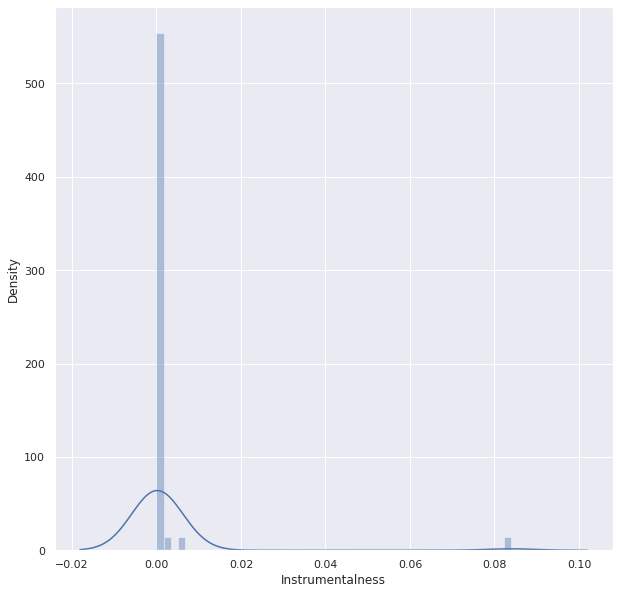

In [47]:
print("Mean value for Instrumentalness:", df_stats['Instrumentalness'].mean())
sns.distplot(df_stats['Instrumentalness'])
plt.show()

Mean value for Liveness: 0.1397744186046511


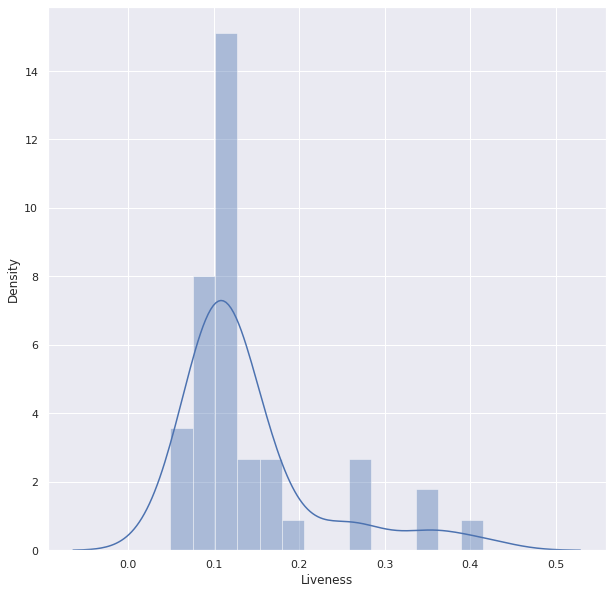

In [48]:
print("Mean value for Liveness:", df_stats['Liveness'].mean())
sns.distplot(df_stats['Liveness'])
plt.show()

Mean value for Valence: 0.42088372093023246


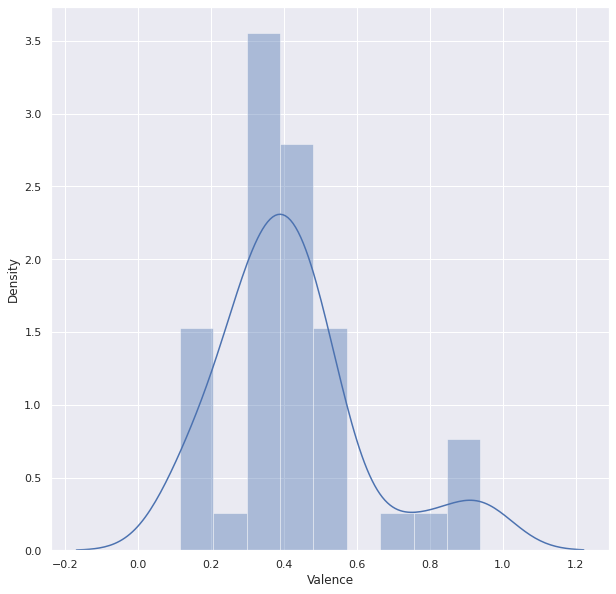

In [49]:
print("Mean value for Valence:", df_stats['Valence'].mean())
sns.distplot(df_stats['Valence'])
plt.show()

Mean value for Tempo: 120.73932558139538


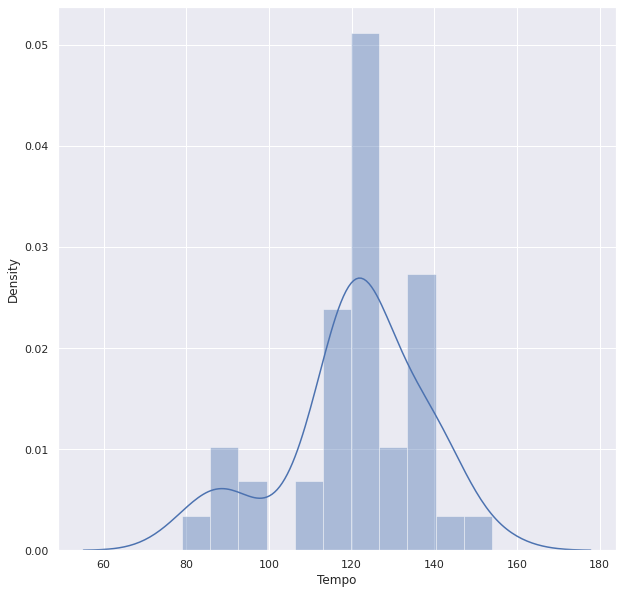

In [50]:
print("Mean value for Tempo:", df_stats['Tempo'].mean())
sns.distplot(df_stats['Tempo'])
plt.show()